## Machine Learning Algorithms for Capstone 1: 

_Sentiment Analysis of Amazon Products Reviews_


__Import Packages__

In [1]:
#General packages
import pandas as pd
import numpy as np
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
# Build figures inline
%matplotlib inline

#NLP packages
import re
import nltk
from wordcloud import WordCloud

#Text preprocessing packages
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [2]:
#load pickled files to DataFrame
baby_products = pd.read_pickle('baby_products_stats.pkl')
grocery_foods = pd.read_pickle('grocery_foods_stats.pkl')
cell_phones = pd.read_pickle('cell_phones_stats.pkl')

In [3]:
baby_products.head(2)

,reviewText,rating,review_summary
0,Perfect for new parents. We were able to keep ...,5,Awesine
1,This book is such a life saver. It has been s...,5,Should be required for all new parents!


In [3]:
# Labeling the dataset
# label: 1 = high rating (rating = 5), label: 0 = low rating (not5)

def label_func(rating):
    if rating == 5:
        return 1
    else:
        return 0
baby_products['label_baby'] = baby_products['rating'].apply(label_func) # labelling baby_products dataset
#grocery_foods['label_food'] = grocery_foods['rating'].apply(label_func) # labeling  grocery_foods dataset
#cell_phones['label_phone'] = cell_phones['rating'].apply(label_func)    # labeling cell_phones dataset
baby_products.head(2)

,reviewText,rating,review_summary,label_baby
0,Perfect for new parents. We were able to keep ...,5,Awesine,1
1,This book is such a life saver. It has been s...,5,Should be required for all new parents!,1


### Text Pre-Processing to reduce document dimension

- Remove URL.
- Remove numbers and Punctuation
- Convert all characters into lowercase
- Tokenization
- Remove Stopwords
- Lemmatization
- convert list of tokens back into the string

In [4]:
# Remove non-English using NLTK

words = set(nltk.corpus.words.words())

def remove_non_en(text):
    text = " ".join(w.lower() for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())
    return text

baby_products['clean_review_baby'] = baby_products['reviewText'].apply(lambda x: remove_non_en(x)) # baby_products dataset
#grocery_foods['clean_review_food'] = grocery_foods['reviewText'].apply(lambda x: remove_non_en(x)) # grocery_foods dataset
#cell_phones['clean_review_phone'] = cell_phones['reviewText'].apply(lambda x: remove_non_en(x)) # cell_phones dataset
baby_products.head(2)


,reviewText,rating,review_summary,label_baby,clean_review_baby
0,Perfect for new parents. We were able to keep ...,5,Awesine,1,perfect for new . we were able to keep track o...
1,This book is such a life saver. It has been s...,5,Should be required for all new parents!,1,this book is such a life saver . it been so he...


In [5]:
# Preprocessing
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

def text_preprocessing(review):
    review = re.sub(r'http\S+', '', review)   # removing URL
    review = re.sub('[^a-zA-Z]', ' ', review) # keep only alpha (removing numbers and punctions)
    review = str(review).lower()              # Lowercase all text
    review = word_tokenize(review)            # Tokenization
    review = [w for w in review if w not in stop_words] # Removing Stopwords
    review = [lemma.lemmatize(word=w, pos='v') for w in review] # Lemmatization
    review = ' '.join(review)
    return review
baby_products['clean_review_baby'] = baby_products['clean_review_baby'].apply(text_preprocessing) # baby_products preprocessiing
#grocery_foods['clean_review_food'] = grocery_foods['clean_review_food'].apply(text_preprocessing) # grocery_foods preprocessing
#cell_phones['clean_review_phone'] = cell_phones['clean_review_phone'].apply(text_preprocessing) # cell_phones preprocessing
baby_products.head(2)

,reviewText,rating,review_summary,label_baby,clean_review_baby
0,Perfect for new parents. We were able to keep ...,5,Awesine,1,perfect new able keep track baby feed sleep di...
1,This book is such a life saver. It has been s...,5,Should be required for all new parents!,1,book life saver helpful able go back track ans...


## Machine Learning on Baby_products Dataset

### Create X and y, split train and test data sets

In [6]:
# store the feature matrix (X) and response vector (y) of dataset
# uppercase X because it's an m x n matrix
# lowercase y because it's a m x 1 vector

X_baby = baby_products.clean_review_baby
y_baby = baby_products.label_baby

print(X_baby.shape)
print(y_baby.shape)

(160662,)
(160662,)


In [7]:
# split the data into training and test sets
X_train_baby, X_test_baby, y_train_baby, y_test_baby = train_test_split(X_baby, y_baby, random_state=42, test_size=0.3)

# Show the results of the split
print("X Training set sample size:", (X_train_baby.shape[0]))
print("X Testing set sample size:", (X_test_baby.shape[0]))
print("y Training set sample size:", (y_train_baby.shape[0]))
print("y Testing set sample size:", (y_test_baby.shape[0]))

X Training set sample size: 112463
X Testing set sample size: 48199
y Training set sample size: 112463
y Testing set sample size: 48199


### Vectorize, fit, create document-term matrix with two vectorizers

In [8]:
# Instantiate CountVectorizer and TfidfVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [9]:
# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_baby)

# examine the document-term matrix
X_train_dtm

<112463x1089423 sparse matrix of type '<class 'numpy.int64'>'
	with 7559470 stored elements in Compressed Sparse Row format>

In [10]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_baby)
X_test_dtm

<48199x1089423 sparse matrix of type '<class 'numpy.int64'>'
	with 2947461 stored elements in Compressed Sparse Row format>

In [11]:
# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_baby = tfidf.fit_transform(X_train_baby)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_baby = tfidf.transform(X_test_baby)
X_test_tfidf_baby

<48199x1089423 sparse matrix of type '<class 'numpy.float64'>'
	with 2947461 stored elements in Compressed Sparse Row format>

### Build baseline model with Naive Bayes and compare vectorizers

In [12]:
# Instantiate MultinomialNB() classifier for CountVectorizer
nb = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb.fit(X_train_dtm, y_train_baby)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_baby, y_pred_class)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_baby, y_pred_class)

# Calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(y_test_baby, y_pred_class)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

F1 Score:  0.8081951610479386

Confusion Matrix:
 [[12511  7651]
 [ 3836 24201]]

AUC:  0.7418522771839783


From the confusion matrix we can see, using CountVectorizer, at baseline the Naive Bayes model 24201 reviews were correctly predicted as 'five' (positive) ratings (TP) and 12511 were correctly predicted as 'not5' (negative) ratings (TN).
However, 7651 reviews were incorrectly predicted to be 'five' (positive) ratings (FP:Type I error) and 3836 reviews were incorrectly predicted to be 'not5' (negative) ratings (FN: Type II error). 

Let's compare it with the TfidfVectorizer.

In [13]:
# COMPARE TFIDF VECTORIZER

# instantiate MultinomialNB() classifier to use on tfidf vectors
nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# train the model 
nb_tfidf.fit(X_train_tfidf_baby, y_train_baby)

# Make class predictions for X_test_tidf_baby
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_baby)

# Calculate F1 Score
f1 = metrics.f1_score(y_test_baby, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test_baby, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_baby)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(y_test_baby, y_prob_tfidf)

print(tfidf)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

F1 Score:  0.7753243478017204

Confusion Matrix:
 [[ 4494 15668]
 [  368 27669]]

AUC:  0.8325516131688426


From the confusion matrix we can see, using TFIDF Vectorizer, at baseline the Naive Bayes model 27669 reviews were correctly predicted as 'five' (positive) ratings (TP) and 4494 were correctly predicted as 'not5' (negative) ratings (TN). However, 15668 reviews were incorrectly predicted to be 'five' (positive) ratings (FP) and 368 reviews were incorrectly predicted to be 'not5' (negative) ratings but they are 'five'(FN).

The TfidfVectorizer with default settings did better in predicting high ratings ('five') but did poorly for low ones ('not5'). Parameters definitely need to be tuned.

### Picking Hyperparameters

I want to look at the __alpha__, __min_df__ and __fit_prior__ to see if I can make the model better.

#### min_df:

___Qusetion: Do I have to use X_train dataset or the whole review dataset (X)?___

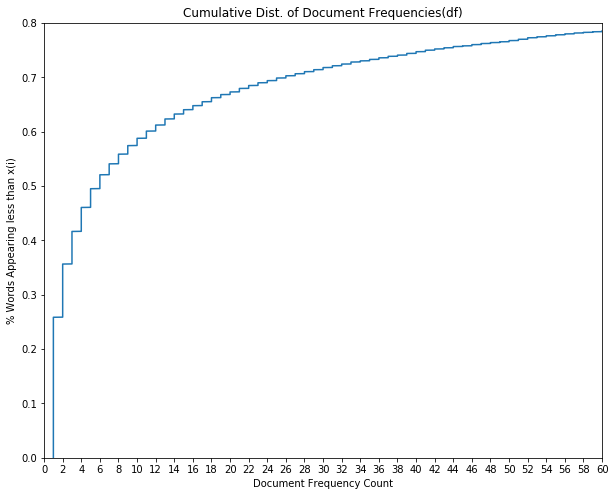

In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_baby) # X_baby = baby_products.clean_review_baby
X = X.tocsc() 


#  to get a count of documents in which a word has appeared, sum it across rows
df = np.sum(X>0,axis=0).tolist()[0]

x_df = np.sort(df)
y_df = np.arange(1, len(df) + 1)/len(df)

fig, ax = plt.subplots(figsize=(10,8))
_ = plt.plot(x_df, y_df)
_ = plt.xlim([0,30])
_ = plt.ylim([0, .8])
_ = plt.xticks([x for x in range(0,62,2)])
_ = plt.title('Cumulative Dist. of Document Frequencies(df)')
_ = plt.xlabel('Document Frequency Count')
_ = plt.ylabel('% Words Appearing less than x(i)')

plt.show()

In [15]:
# best min_df for CountVectorizer

values_dict = {}
pos_df = [.0001, .001, .01, .1, 1, 2, 3, 4, 5, 6]

for min_df in pos_df:
    vect = CountVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_dtm = vect.fit_transform(X_train_baby)
    X_test_dtm = vect.transform(X_test_baby)
    nb = MultinomialNB(alpha=1, fit_prior=True)
    nb.fit(X_train_dtm, y_train_baby)
    y_pred_class = nb.predict(X_test_dtm)
    f1 = metrics.f1_score(y_test_baby, y_pred_class)
    y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]
    auc = metrics.roc_auc_score(y_test_baby, y_pred_class)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))
    
best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.7570805457143218, Min_df: 0.0001, F1: 0.803446
AUC: 0.7471393649237659, Min_df: 0.001, F1: 0.796200
AUC: 0.7282880816472637, Min_df: 0.01, F1: 0.784735
AUC: 0.6221189835033026, Min_df: 0.1, F1: 0.727414
AUC: 0.7418522771839783, Min_df: 1, F1: 0.808195
AUC: 0.7511579724932828, Min_df: 2, F1: 0.805253
AUC: 0.7536483702327161, Min_df: 3, F1: 0.804435
AUC: 0.75552219163733, Min_df: 4, F1: 0.804516
AUC: 0.7556182808469218, Min_df: 5, F1: 0.803656
AUC: 0.7548656626766711, Min_df: 6, F1: 0.803090

 Best Values: 
 Min_df: 0.0001, AUC: 0.7570805457143218, F1: 0.803446


In [16]:
# best min_df for TfidfVectorizer
values_dict = {}
pos_df = [.0001, .001, .01, .1, 1, 2, 3, 4, 5, 6]

for min_df in pos_df:
    tfidf = TfidfVectorizer(min_df=min_df, ngram_range=(1, 2)) 
    X_train_tfidf_baby = tfidf.fit_transform(X_train_baby)
    X_test_tfidf_baby = tfidf.transform(X_test_baby)
    nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)
    nb_tfidf.fit(X_train_tfidf_baby, y_train_baby)
    y_pred_tfidf = nb_tfidf.predict(X_test_tfidf_baby)
    f1 = metrics.f1_score(y_test_baby, y_pred_tfidf)
    y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf_baby)[:,1]
    auc = metrics.roc_auc_score(y_test_baby, y_prob_tfidf)
    values_dict[auc] = [f1, min_df]
    print("AUC: {}, Min_df: {}, F1: {:4f}".format(auc, min_df, f1))

best_auc = max(values_dict.keys())
best_f1 = values_dict[max(values_dict.keys())][0]
best_min_df = values_dict[max(values_dict.keys())][1]
print('\n Best Values: \n Min_df: {}, AUC: {}, F1: {:4f}'.format(best_min_df, best_auc, best_f1))

AUC: 0.8419901678311728, Min_df: 0.0001, F1: 0.812816
AUC: 0.8331396550727564, Min_df: 0.001, F1: 0.806319
AUC: 0.812540886451798, Min_df: 0.01, F1: 0.793671
AUC: 0.6940585984771346, Min_df: 0.1, F1: 0.744600
AUC: 0.8325516131688426, Min_df: 1, F1: 0.775324
AUC: 0.8409721997973282, Min_df: 2, F1: 0.798152
AUC: 0.8427480355937182, Min_df: 3, F1: 0.808464
AUC: 0.8432626955388217, Min_df: 4, F1: 0.811943
AUC: 0.8433075581034694, Min_df: 5, F1: 0.813064
AUC: 0.8428389017464442, Min_df: 6, F1: 0.812808

 Best Values: 
 Min_df: 5, AUC: 0.8433075581034694, F1: 0.813064


Best min_df for CountVectorizer is 0.0001 and for TfidfVectorizer is 5.


#### GridSearchCV

__Run GridSearchCV on best parameters for CountVectorizer__

In [17]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [18]:
# Create a list of parameters for tuning
parameters = {'fit_prior': (True, False),
              'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
             }

In [19]:
# Instantiate Vectorizer with new min_df 
vect = CountVectorizer(min_df=.0001, ngram_range=(1, 2)) 

# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train_baby)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test_baby)

# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_count.fit(X_train_dtm, y_train_baby)

# View the best score (set to roc_auc) for MultinomialNB with CountVect
print(gs_count)
print('\nBest Score: ', gs_count.best_score_)

# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_count.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Best Score:  0.8283025959053957
Best parameters: {'alpha': 5, 'fit_prior': False}


__Run GridSearchCV on best parameters for TfidfVectorizer__

In [20]:
# Instantiate Vectorizer with new min_df 
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2))

# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf_baby = tfidf.fit_transform(X_train_baby)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf_baby = tfidf.transform(X_test_baby)


# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_tfidf.fit(X_train_tfidf_baby, y_train_baby)

# View the best score (set to roc_auc) for MultinomialNB with TfidfVect
print(gs_tfidf)
print('\nBest Score: ', gs_tfidf.best_score_)

# Get best parameters for MultinomialNB with TfidfVect
print('Best parameters:', gs_tfidf.best_params_)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Best Score:  0.8429549313988307
Best parameters: {'alpha': 1, 'fit_prior': True}


__Interpretation:__

The Naive Bayes model using a minimum document frequency of .0001 and 5 for CountVectorizer and TfidfVectorizer respectively performs well. GridSearchCV indicated that the best parameters for TfidfVectorizer were the default ones but for CountVectorizer it was different ('alpha': 5, 'fit_prior': False). For further algorithms I will continue to use the TfidfVectorizer because it provided slightly better results.For the rest of the algorithms I will use the document terms matrix from the TfidfVectorizer because it has better score.

Next I will look further into the text to further improve the model amongst other algorithms and classifiers. 

In [21]:
# Calculate predicted probabilities for X_test_tfidf_baby
y_prob_nb = gs_tfidf.predict_proba(X_test_tfidf_baby)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test_baby, y_prob_nb)

print('AUC: ', auc)

AUC:  0.8433075581034694


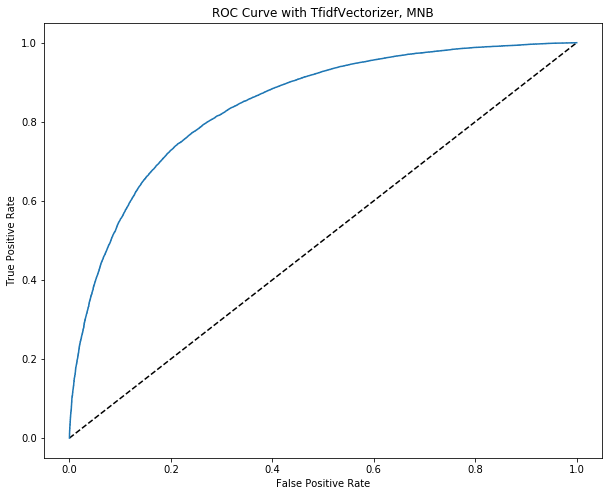

In [22]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_baby, y_prob_nb)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer, MNB')
plt.show()

### Most Predictive Features

In [ ]:
words = np.array(tfidf.get_feature_names())

# Create an identity matrix the length of the vocabulary
x = np.eye(X_test_tfidf_baby.shape[1]) 

# Use the model to predict on the identity matrix, and get a list of probabilities for each word
probs = gs_tfidf.predict_log_proba(x)[:,0] 

# Sort for most/least probable words for any give class
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(five (positive) | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(five (positive) | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))